# Notebook to run prediction on corrupted datasets. 

In [ ]:
"""Script to benchmark an existing ensemble on corrupted versions of a video with groundtruth labels. 

Assumes you have the following: 
- notebook running in an environment with dgp,dgp dependencies, and dgp_ensembletools module (from this repository) installed
- pre-trained ensembles of networks, indicated here with the ensemblepaths dictionaries. Each ensemblepaths[value]
path points to a folder with the following structure: 
    /
    |-1
      |-config.yaml
      |-labeled-data
      |-videos    
      |-dlc-models
      |-training-datasets
      |-videos_pred
    |-2
    |-3
    ...
    |-N
- Groundtruth data against which we will benchmark the individual network and ensemble detections. 
- A directory containing the corrupted videos, with names as {taskname}_{corruption}_{severity}_{datetime}.{extension}.
We will assume two base videos, "ibl1.mp4", and "b29_post_side_1min.mp4" that generate these corruptions, with 
severity in [1,3] for ibl, and severity = 3 for b29. We further assume that the base video has already been predicted on, and
is located in the vides/ folder of the corresponding model 
"""

# Predictions on the ibl dataset.

In [2]:
import dgp_ensembletools.models
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import joblib 
import os

import deeplabcut.utils.auxiliaryfunctions as auxiliaryfunctions
from deepgraphpose.models.eval import load_pose_from_dlc_to_dict
from deepgraphpose.utils_model import get_train_config
from pathlib import Path
import os
from deepgraphpose.models.fitdgp_util import get_snapshot_path
import pandas as pd

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


## Create ensemble for the ibl dataset. 

In [2]:
num_trains = 5
num_seeds = 9
#training_subsets = np.round(np.linspace(0.1,0.9, num_trains), 2)
training_subsets = {""}
training_seed = np.arange(1, num_seeds+1).astype('int')

ensemblepaths = {10:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results",
                 30:"/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_30p_real/process_results",
                 50:"/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_50p_real/process_results",
                 70:"/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results",
                 90:"/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_90p_real/process_results"}
ensemble = dgp_ensembletools.models.Ensemble(ensemblepaths[90],[str(i+1) for i in range(num_seeds)],"mp4",memory=joblib.Memory("/home/ubuntu/ensembledata_2/cache"))

## Get a dictionary of corrupted video names:

In [3]:
# Get corrupted videos: 
viddir = "/home/ubuntu/testvids/corrupted_videos/"
vids = os.listdir(viddir)
videoname = "ibl1"
corruptions = {"pixelate":[1,3],
              "contrast":[1,3],
              "shot_noise":[1,3],
              "gaussian_noise":[1,3],
              "brightness":[1,3],
              "motion_blur":[1,3],
              "jpeg_compression":[1,3]}

video_prefixes = [f"{videoname}_{corrk}_{corrsi}" for corrk,corrs in corruptions.items() for corrsi in corrs]
videos = {vp:[v for v in vids if v.startswith(vp)] for vp in video_prefixes}
videos["ibl1"] = ["ibl1.mp4"]

In [5]:
videos

{'ibl1_pixelate_1': ['ibl1_pixelate_1_20_04_2021-11_08_34.mp4'],
 'ibl1_pixelate_3': ['ibl1_pixelate_3_20_04_2021-11_20_31.mp4'],
 'ibl1_contrast_1': ['ibl1_contrast_1_20_04_2021-11_05_47.mp4'],
 'ibl1_contrast_3': ['ibl1_contrast_3_20_04_2021-11_17_03.mp4'],
 'ibl1_shot_noise_1': ['ibl1_shot_noise_1_20_04_2021-11_03_30.mp4'],
 'ibl1_shot_noise_3': ['ibl1_shot_noise_3_20_04_2021-11_12_32.mp4'],
 'ibl1_gaussian_noise_1': ['ibl1_gaussian_noise_1_20_04_2021-11_02_36.mp4'],
 'ibl1_gaussian_noise_3': ['ibl1_gaussian_noise_3_20_04_2021-11_11_38.mp4'],
 'ibl1_brightness_1': ['ibl1_brightness_1_20_04_2021-11_06_06.mp4'],
 'ibl1_brightness_3': ['ibl1_brightness_3_20_04_2021-11_17_32.mp4'],
 'ibl1_motion_blur_1': ['ibl1_motion_blur_1_20_04_2021-11_04_51.mp4'],
 'ibl1_motion_blur_3': ['ibl1_motion_blur_3_20_04_2021-11_13_29.mp4'],
 'ibl1_jpeg_compression_1': ['ibl1_jpeg_compression_1_20_04_2021-11_08_42.mp4'],
 'ibl1_jpeg_compression_3': ['ibl1_jpeg_compression_3_20_04_2021-11_20_43.mp4'],
 'ibl1

## predict on the corrupted videos: 

In [6]:
for vid,vidinst in videos.items():
    for vidi in vidinst:
        [model.predict(os.path.join(viddir,vidi)) for model in ensemble.models.values()]

## Generate consensus output and compare:
### First we need to get the set of all test frames: 

In [7]:
## get test error. 
train_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
test_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
train_error_ensemble = np.zeros((num_trains,))*np.nan
test_error_ensemble = np.zeros((num_trains,))*np.nan
epsilon = 0
#nc = 200
ws_flag = None
#%%
task="ibl1"
scorer="kelly"
data_directory = "/home/ubuntu/ensembledata/"
training_subsets = {"job__ensemble-dgp_2_20_30p_real":10}


video_folder = ""
traces_folder = "videos_pred/{}_labeled.csv".format(task)
heatmaps_folder = "videos_pred/{}_labeled.npy".format(task)
shuffle=1
trainingsetindex=0
#%%
train_indices = [[]]*num_trains
test_indices = [[]]*num_trains
heatmap_indices = [[]]*num_trains
train_indices = {}
test_indices = {}
heatmap_indices = {}
skipped_seed = [[]]*num_trains
for train_fraction,ensemblepath in ensemblepaths.items():
    print("\n\n{}".format(train_fraction))
    heatmaps_files = []
    train_frames_ensemble = []
    test_frames_ensemble = []
    for seed_idx, seed in enumerate(training_seed):
        #date = "2050-{:02d}-{:02d}".format(date_idx + 1, seed)
        cfg_folder = str(Path(data_directory)/ "{}".format(ensemblepath)/"{}".format(seed))
        cfg_yaml = str(Path(cfg_folder)/ "config.yaml")
        cfg = auxiliaryfunctions.read_config(cfg_yaml)
        cfg["project_path"] = os.path.join(data_directory,ensemblepath,str(seed))
        label_file = str(Path(cfg_folder)/ traces_folder)
        print(label_file)
        try:
            labels = load_pose_from_dlc_to_dict(label_file)
            xr_dgp = labels['x'] # T x D
            yr_dgp = labels['y']
        except:
            skipped_seed[date_idx].append(seed_idx)
            continue
        # ------
        # get train/test sets (indices for video)
        trainingsetfolder = auxiliaryfunctions.GetTrainingSetFolder(cfg)
        datafn, metadatafn = auxiliaryfunctions.GetDataandMetaDataFilenames(
            trainingsetfolder, cfg['TrainingFraction'][trainingsetindex], shuffle, cfg)
        # Load meta data
        data, trainIndices, testIndices, trainFraction = auxiliaryfunctions.LoadMetadata(
            os.path.join(data_directory,ensemblepath,str(seed), metadatafn))
        # the train indices are the indices of the labeled frames? or the video itself
        # they are of the training set, so read the indices of the video
        Data = pd.read_hdf(os.path.join(data_directory,ensemblepath,str(seed), str(trainingsetfolder),
                                        'CollectedData_' + cfg["scorer"] + '.h5'),
                           'df_with_missing') #* dlc_cfg['global_scale']
        num_labels, _ = Data.values.shape
        labeled_frames = np.empty(num_labels).astype('int')
        for frame_idx in range(num_labels):
            idx_name = int(Path(Data.iloc[frame_idx].name).stem[3:])
            labeled_frames[frame_idx] = idx_name
        # Video frames user for training and testing:
        train_frames = labeled_frames[trainIndices]
        test_frames = labeled_frames[testIndices]
        # --- store confidence map to then calculate ensemble from heatmaps
        #last_snapshot, snapshot_data = get_last_snapshot(cfg_folder)
        last_snapshot = "snapshot-step2-final--0"
        assert "step2-final"  in last_snapshot
        print(cfg_folder.rsplit("/", 1)[-1], last_snapshot)
        # continue
        snapshot_path, cfg_yaml = get_snapshot_path(last_snapshot, cfg_folder,
                                                    shuffle=shuffle)
        #cfg = auxiliaryfunctions.read_config(cfg_yaml)
        video_file = Path(cfg_folder) / "videos/{}.mp4".format(task)
        video_pred_path = str(Path(cfg_folder) / 'videos_pred')
        print(snapshot_path)
#         _ = estimate_pose(
#                  proj_cfg_file=str(cfg_yaml),
#                  dgp_model_file=str(snapshot_path),
#                  video_file=str(video_file),
#                  output_dir=str(video_pred_path),
#                  shuffle=shuffle,
#                  save_str=last_snapshot,
#                  save_heatmap=True)
        heatmap_file = str(Path(cfg_folder) / heatmaps_folder)
        heatmaps_files.append(heatmap_file)
        train_frames_ensemble.append(train_frames)
        test_frames_ensemble.append(test_frames)
    # calculate ensemble loss using the heatmaps stored in npy labeled folder
    video_sets = list(cfg['video_sets'].keys())
    video_name = video_sets[0]
    cfg['video_path']=  Path(data_directory,ensemblepath,str(seed)) / video_name
    dlc_cfg = get_train_config(cfg, shuffle=shuffle)
    # train and test frames to use for ensemble
    train_indices[train_fraction] = train_frames_ensemble
    test_indices[train_fraction] = test_frames_ensemble 
    heatmap_indices[train_fraction] = heatmaps_files



10
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/1/videos_pred/ibl1_labeled.csv
1 snapshot-step2-final--0
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/1/dlc-models/iteration-0/iblrightJan1-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/2/videos_pred/ibl1_labeled.csv
2 snapshot-step2-final--0
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/2/dlc-models/iteration-0/iblrightJan2-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/3/videos_pred/ibl1_labeled.csv
3 snapshot-step2-final--0
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/3/dlc-models/iteration-0/iblrightJan3-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results/4/videos_pred/ibl1_labeled.csv
4 snapshot-

/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/3/videos_pred/ibl1_labeled.csv
3 snapshot-step2-final--0
/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/3/dlc-models/iteration-0/iblrightJan3-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/4/videos_pred/ibl1_labeled.csv
4 snapshot-step2-final--0
/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/4/dlc-models/iteration-0/iblrightJan4-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/5/videos_pred/ibl1_labeled.csv
5 snapshot-step2-final--0
/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/5/dlc-models/iteration-0/iblrightJan5-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_2/job__ensemble-dgp_2_24_70p_real/process_results/6/videos_pred/ibl1_labeled.csv
6 

In [8]:
all_testframes = {}
for trainfrac in ensemblepaths:
    train_frames = np.unique(np.concatenate(train_indices[trainfrac]))
    test_frames = np.setdiff1d(np.arange(1000),train_frames).astype('int')
    all_testframes[trainfrac] = test_frames

## Generate the ensemble rmses for all corrupted videos:

In [10]:
# dgp_ensembletools.models.memory = joblib.Memory(os.path.join(os.getenv("HOME"),"ensembledata_2","cache"))
#get the ensemlbe rmse per corruption type on the first video of a given severity. 
ensemble_rmses = {vid:ensemble.compare_groundtruth(videoname=os.path.splitext(vidinst[0])[0]+"_labeled"+os.path.splitext(vidinst[0])[1],
                             groundtruthpath = "/home/ubuntu/ibl1_true_xy_all_918pm.mat",
                             partperm=[1,3,0,2],
                             indices = all_testframes[90]) for vid,vidinst in videos.items()}

snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project co

scaling refs.
(948, 2, 4)
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--

scaling refs.
(948, 2, 4)
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--

scaling refs.
(948, 2, 4)


## Plot results:

<IPython.core.display.Javascript object>


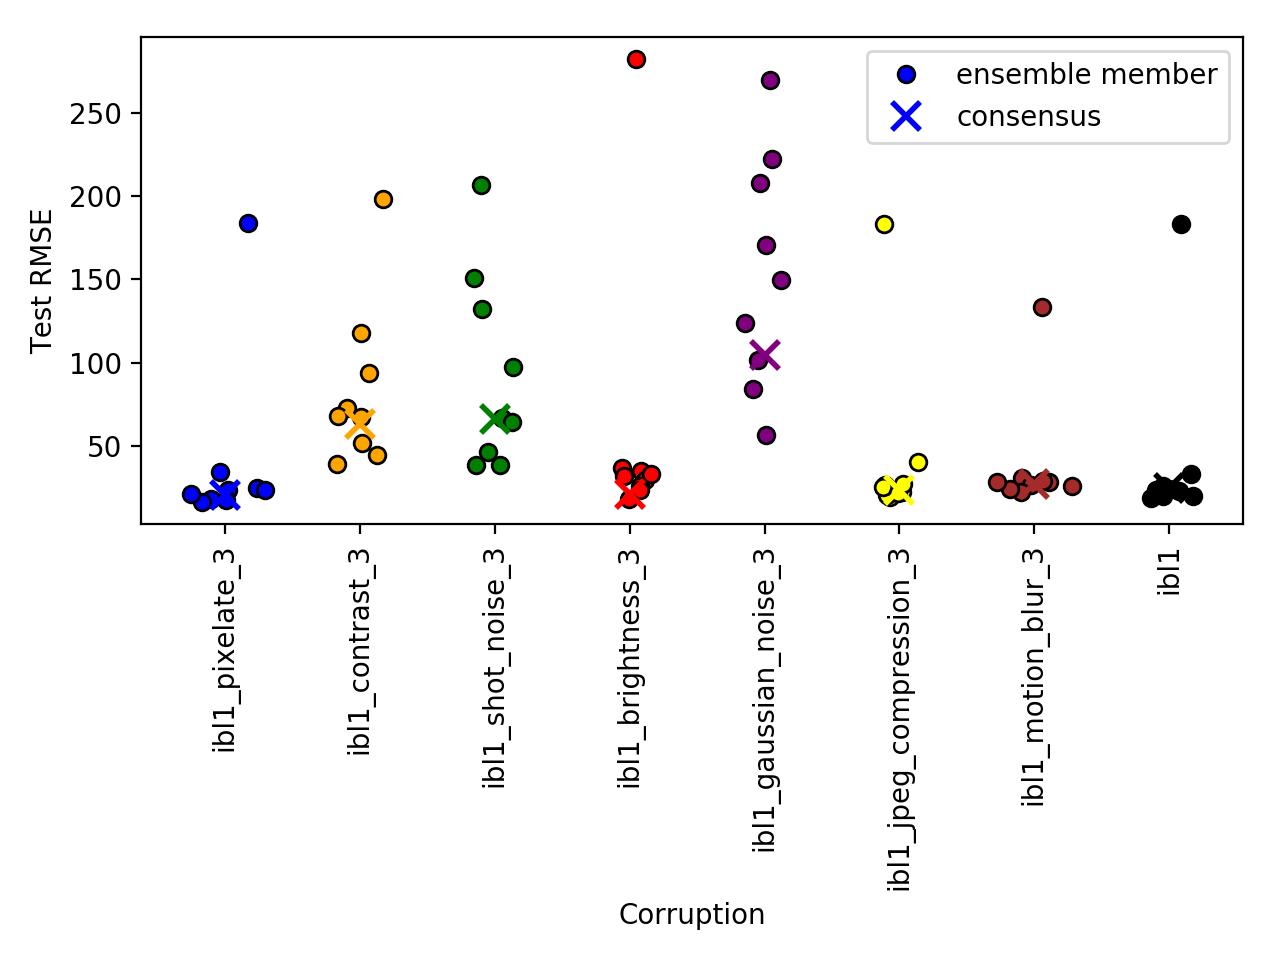

[184.07181359412206, 24.696637883836654, 34.0379139438029, 23.14344980053124, 17.07707509579107, 17.63505573482591, 23.233036581855593, 16.082736073346585, 20.652438633114645]
[93.75143923540371, 198.26872725442965, 72.8017732411395, 67.50807563878746, 51.757263069205074, 44.58360522257196, 38.805796018417745, 68.11947699136775, 117.97729204383666]
[151.14178204638225, 97.59297562524539, 206.6949822223598, 38.50189880276005, 66.60551317281734, 46.40523999207881, 38.12120468872527, 64.5363792332874, 131.91872037813965]
[282.52882434586814, 17.91822310724822, 34.98186806008794, 29.25444172607601, 25.59215025245043, 23.477197326102022, 32.748861987968944, 36.35750551474638, 31.71146285612113]
[222.29297601559662, 207.8885927347038, 270.17788960115564, 149.81372489643226, 56.53280112689804, 123.55044099590224, 101.4579820517281, 83.92704087324722, 170.8765521648652]
[183.3523686126808, 26.494241172676542, 40.10310260206958, 21.906146233157195, 18.936054762199902, 20.17502058003466, 24.9561

In [28]:
plt.style.use("default")
interval = 20
corrs3 = ["ibl1_pixelate_3",
         "ibl1_contrast_3",
         "ibl1_shot_noise_3",
         "ibl1_brightness_3",
         "ibl1_gaussian_noise_3",
         "ibl1_jpeg_compression_3",
         "ibl1_motion_blur_3",
         "ibl1"]
colors = ["blue","orange","green","red","purple","yellow","brown","black"]
ensemble = [i for i in range(9)]
fig,ax = plt.subplots()
for pi,p in enumerate(corrs3):
    jit = np.random.randn(len(ensemble))*3
    vals = ensemble_rmses[p]
    ensvals = [vals[i] for i in ensemble]
    print(ensvals)
    if pi == 0:
        ax.plot([pi*interval+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],label = "ensemble member",markeredgecolor = "black")
        ax.plot(pi*interval,vals["median"],marker = "x",color=colors[pi],label = "consensus",markersize = 10,linestyle="None",markeredgewidth=2)
    else:
        ax.plot([pi*interval+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],markeredgecolor = "black")
        ax.plot(pi*interval,vals["median"],marker = "x",color=colors[pi],markersize = 10,linestyle = "None",markeredgewidth=2)
ax.set_ylabel("Test RMSE")
ax.set_xlabel("Corruption")
ax.set_xticks([i*interval for i in range(len(corrs3))])
plt.legend(numpoints = 1)
ax.set_xticklabels(["{}".format(cr) for cr in corrs3],rotation ="vertical")
plt.tight_layout()
plt.savefig("rmseplot_corrupted_ibl_severity_3.png")

<IPython.core.display.Javascript object>


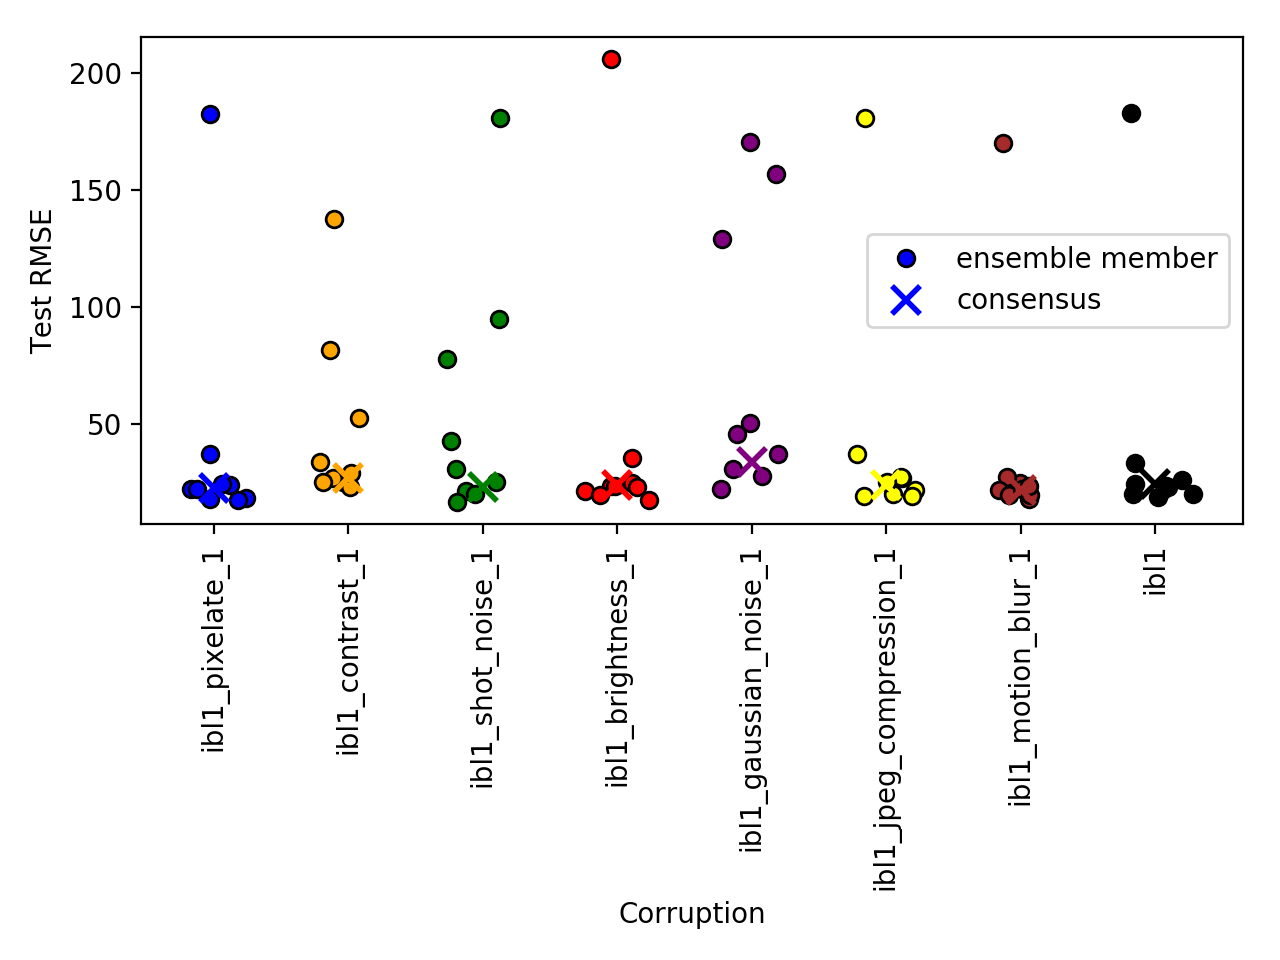

[182.63726762392858, 23.63768673469009, 36.930573592828914, 21.984354238956705, 18.232574068945386, 17.801025684569804, 21.753273036607776, 17.06008801813154, 24.17209717069458]
[137.6455578382997, 81.32395832612325, 33.712837593372726, 25.01258934533982, 26.728462534503986, 22.929446135033842, 24.8337833496688, 28.938501481617713, 52.5393852360148]
[180.88228259320886, 42.65532398806272, 94.63587677349808, 25.130052252016114, 21.25577478887296, 19.841569430733607, 30.61924285235981, 16.47625809173517, 77.49609163809129]
[206.0788284379672, 24.35480910311126, 35.08346983122661, 23.259192501266675, 21.190831686599473, 17.14893793683083, 23.184745538101556, 19.548111916121375, 22.991351133471973]
[156.76170732281778, 128.97589083237952, 170.63801562642348, 45.56285087258373, 36.92686230907945, 30.34456337689978, 27.385482567082395, 21.757052042874008, 50.292281095309846]
[180.8158883877054, 26.48204512962027, 36.775620076195096, 21.737559108974732, 18.803953449432047, 18.844546400968905,

In [27]:
plt.style.use("default")
interval = 20
corrs3 = ["ibl1_pixelate_1",
         "ibl1_contrast_1",
         "ibl1_shot_noise_1",
         "ibl1_brightness_1",
         "ibl1_gaussian_noise_1",
         "ibl1_jpeg_compression_1",
         "ibl1_motion_blur_1",
         "ibl1"]
colors = ["blue","orange","green","red","purple","yellow","brown","black"]
ensemble = [i for i in range(9)]
fig,ax = plt.subplots()
for pi,p in enumerate(corrs3):
    jit = np.random.randn(len(ensemble))*3
    vals = ensemble_rmses[p]
    ensvals = [vals[i] for i in ensemble]
    print(ensvals)
    if pi == 0:
        ax.plot([pi*interval+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],label = "ensemble member",markeredgecolor = "black")
        ax.plot(pi*interval,vals["median"],marker = "x",color=colors[pi],label = "consensus",markersize = 10,linestyle="None",markeredgewidth=2)
    else:
        ax.plot([pi*interval+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],markeredgecolor = "black")
        ax.plot(pi*interval,vals["median"],marker = "x",color=colors[pi],markersize = 10,linestyle = "None",markeredgewidth=2)
ax.set_ylabel("Test RMSE")
ax.set_xlabel("Corruption")
ax.set_xticks([i*interval for i in range(len(corrs3))])
plt.legend(numpoints = 1)
ax.set_xticklabels(["{}".format(cr) for cr in corrs3],rotation ="vertical")
plt.tight_layout()
plt.savefig("rmseplot_corrupted_ibl_severity_1.png")

## predictions on the two mouse dataset. 

In [3]:
import dgp_ensembletools.models
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import joblib 
import os

import deeplabcut.utils.auxiliaryfunctions as auxiliaryfunctions
from deepgraphpose.models.eval import load_pose_from_dlc_to_dict
from deepgraphpose.utils_model import get_train_config
from pathlib import Path
import os
from deepgraphpose.models.fitdgp_util import get_snapshot_path
import pandas as pd

In [5]:
num_trains = 5
num_seeds = 9
#training_subsets = np.round(np.linspace(0.1,0.9, num_trains), 2)
training_subsets = {""}
training_seed = np.arange(1, num_seeds+1).astype('int')

ensemblepaths = {20:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results",
                 40:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_40p_real/process_results",
                 60:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results",
                 80:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results",
                 100:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results"}
# ensemblepaths = {10:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results",
#                  30:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_30p_real/process_results",
#                  50:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_50p_real/process_results",
#                  70:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_70p_real/process_results",
#                  90:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_20_90p_real/"}
#%%
train_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
test_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
train_error_ensemble = np.zeros((num_trains,))*np.nan
test_error_ensemble = np.zeros((num_trains,))*np.nan
epsilon = 0
#nc = 200
ws_flag = None
#%%
task="B29_post_side_15"
scorer="erica"
data_directory = "/home/ubuntu/ensembledata_3/"
training_subsets = {"job__ensemble-dgp_3_14_20p_real":20}


video_folder = ""
traces_folder = "videos_pred/{}_labeled.csv".format(task)
heatmaps_folder = "videos_pred/{}_labeled.npy".format(task)
shuffle=1
trainingsetindex=0
#%%
train_indices = [[]]*num_trains
test_indices = [[]]*num_trains
heatmap_indices = [[]]*num_trains
train_indices = {}
test_indices = {}
heatmap_indices = {}
skipped_seed = [[]]*num_trains
for train_fraction,ensemblepath in ensemblepaths.items():
    print("\n\n{}".format(train_fraction))
    heatmaps_files = []
    train_frames_ensemble = []
    test_frames_ensemble = []
    for seed_idx, seed in enumerate(training_seed):
        #date = "2050-{:02d}-{:02d}".format(date_idx + 1, seed)
        cfg_folder = str(Path(data_directory)/ "{}".format(ensemblepath)/"{}".format(seed))
        cfg_yaml = str(Path(cfg_folder)/ "config.yaml")
        cfg = auxiliaryfunctions.read_config(cfg_yaml)
        cfg["project_path"] = os.path.join(data_directory,ensemblepath,str(seed))
        label_file = str(Path(cfg_folder)/ traces_folder)
        print(label_file)
        try:
            labels = load_pose_from_dlc_to_dict(label_file)
            xr_dgp = labels['x'] # T x D
            yr_dgp = labels['y']
        except:
            skipped_seed[date_idx].append(seed_idx)
            continue
        # ------
        # get train/test sets (indices for video)
        trainingsetfolder = auxiliaryfunctions.GetTrainingSetFolder(cfg)
        datafn, metadatafn = auxiliaryfunctions.GetDataandMetaDataFilenames(
            trainingsetfolder, cfg['TrainingFraction'][trainingsetindex], shuffle, cfg)
        # Load meta data
        data, trainIndices, testIndices, trainFraction = auxiliaryfunctions.LoadMetadata(
            os.path.join(data_directory,ensemblepath,str(seed), metadatafn))
        # the train indices are the indices of the labeled frames? or the video itself
        # they are of the training set, so read the indices of the video
        Data = pd.read_hdf(os.path.join(data_directory,ensemblepath,str(seed), str(trainingsetfolder),
                                        'CollectedData_' + cfg["scorer"] + '.h5'),
                           'df_with_missing') #* dlc_cfg['global_scale']
        num_labels, _ = Data.values.shape
        labeled_frames = np.empty(num_labels).astype('int')
        for frame_idx in range(num_labels):
            idx_name = int(Path(Data.iloc[frame_idx].name).stem[3:])
            labeled_frames[frame_idx] = idx_name
        # Video frames user for training and testing:
        train_frames = labeled_frames[trainIndices]
        test_frames = labeled_frames[testIndices]
        # --- store confidence map to then calculate ensemble from heatmaps
        #last_snapshot, snapshot_data = get_last_snapshot(cfg_folder)
        last_snapshot = "snapshot-step2-final--0"
        assert "step2-final"  in last_snapshot
        print(cfg_folder.rsplit("/", 1)[-1], last_snapshot)
        # continue
        snapshot_path, cfg_yaml = get_snapshot_path(last_snapshot, cfg_folder,
                                                    shuffle=shuffle)
        #cfg = auxiliaryfunctions.read_config(cfg_yaml)
        video_file = Path(cfg_folder) / "videos/{}.mp4".format(task)
        video_pred_path = str(Path(cfg_folder) / 'videos_pred')
        print(snapshot_path)
#         _ = estimate_pose(
#                  proj_cfg_file=str(cfg_yaml),
#                  dgp_model_file=str(snapshot_path),
#                  video_file=str(video_file),
#                  output_dir=str(video_pred_path),
#                  shuffle=shuffle,
#                  save_str=last_snapshot,
#                  save_heatmap=True)
        heatmap_file = str(Path(cfg_folder) / heatmaps_folder)
        heatmaps_files.append(heatmap_file)
        train_frames_ensemble.append(train_frames)
        test_frames_ensemble.append(test_frames)
    # calculate ensemble loss using the heatmaps stored in npy labeled folder
    video_sets = list(cfg['video_sets'].keys())
    video_name = video_sets[0]
    cfg['video_path']=  Path(data_directory,ensemblepath,str(seed)) / video_name
    dlc_cfg = get_train_config(cfg, shuffle=shuffle)
    # train and test frames to use for ensemble
    train_indices[train_fraction] = train_frames_ensemble
    test_indices[train_fraction] = test_frames_ensemble 
    heatmap_indices[train_fraction] = heatmaps_files



20
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/1/videos_pred/B29_post_side_15_labeled.csv
1 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/2/videos_pred/B29_post_side_15_labeled.csv
2 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/3/videos_pred/B29_post_side_15_labeled.csv
3 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20

9 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml


80
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/1/videos_pred/B29_post_side_15_labeled.csv
1 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/2/videos_pred/B29_post_side_15_labeled.csv
2 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/

In [6]:
all_testframes = {}
for trainfrac in ensemblepaths:
    train_frames = np.unique(np.concatenate(train_indices[trainfrac]))
    test_frames = np.setdiff1d(np.arange(1000),train_frames).astype('int')
    all_testframes[trainfrac] = test_frames

In [7]:
ensembles = {prop:dgp_ensembletools.models.Ensemble(path,[str(i+1) for i in range(9)],"mp4",memory = joblib.Memory("/home/ubuntu/ensembledata_3")) for prop,path in ensemblepaths.items()}
ensemble = ensembles[100]

In [8]:
# Get corrupted videos: 
viddir = "/home/ubuntu/testvids/corrupted_videos_erica/"
vids = os.listdir(viddir)
videoname = "b29_post_side_1min"
corruptions = {"pixelate":[3],
              "contrast":[3],
              "shot_noise":[3],
              "gaussian_noise":[3],
              "brightness":[3],
              "motion_blur":[3],
              "jpeg_compression":[3]}

video_prefixes = [f"{videoname}_{corrk}_{corrsi}" for corrk,corrs in corruptions.items() for corrsi in corrs]
videos = {vp:[v for v in vids if v.startswith(vp)] for vp in video_prefixes}
videos["b29_post_side_1min"] = ["b29_post_side_1min.mp4"]

In [12]:
# for vid,vidinst in videos.items():
#     for vidi in vidinst:
#         [model.predict(os.path.join(viddir,vidi)) for model in ensemble.models.values()]

snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:25<00:00, 70.08it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 30/1800 [00:00<00:05, 299.93it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1034/1800 [00:02<00:02, 339.56it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 77.77it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 28/1800 [00:00<00:06, 279.25it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1043/1800 [00:02<00:02, 368.14it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.77it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 309.07it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▊    | 1035/1800 [00:02<00:02, 342.81it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.69it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 28/1800 [00:00<00:06, 278.08it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1059/1800 [00:03<00:02, 354.00it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.92it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 324.66it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1045/1800 [00:02<00:02, 360.09it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.45it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 322.38it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1044/1800 [00:02<00:02, 335.82it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.58it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 324.99it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1038/1800 [00:02<00:02, 326.68it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 79.04it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 328.15it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1059/1800 [00:03<00:02, 323.62it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.56it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 34/1800 [00:00<00:05, 331.62it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1067/1800 [00:03<00:02, 345.05it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 79.19it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 34/1800 [00:00<00:05, 338.21it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1067/1800 [00:02<00:01, 400.38it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.85it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 35/1800 [00:00<00:05, 345.34it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▊    | 1057/1800 [00:02<00:01, 385.77it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 79.00it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 35/1800 [00:00<00:05, 342.96it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1046/1800 [00:02<00:01, 388.67it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 79.07it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 30/1800 [00:00<00:06, 293.02it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▊    | 1057/1800 [00:03<00:01, 376.63it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.51it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 36/1800 [00:00<00:04, 353.73it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▊    | 1057/1800 [00:03<00:01, 383.14it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.65it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 34/1800 [00:00<00:05, 337.05it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1050/1800 [00:02<00:01, 388.25it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 79.02it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 327.28it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1058/1800 [00:02<00:01, 379.67it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.88it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 34/1800 [00:00<00:05, 332.67it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1047/1800 [00:02<00:02, 365.65it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.84it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 35/1800 [00:00<00:05, 343.05it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1040/1800 [00:02<00:02, 368.38it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_contrast_3_20_04_2021-11_35_10_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 78.10it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 21/1800 [00:00<00:08, 203.10it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1046/1800 [00:04<00:03, 240.69it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.31it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 20/1800 [00:00<00:09, 196.43it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1039/1800 [00:04<00:03, 246.35it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.45it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 22/1800 [00:00<00:08, 213.84it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1027/1800 [00:04<00:03, 240.82it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.41it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 19/1800 [00:00<00:09, 186.25it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1037/1800 [00:04<00:03, 236.59it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 78.12it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 20/1800 [00:00<00:09, 195.25it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1038/1800 [00:04<00:03, 224.48it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 78.17it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 20/1800 [00:00<00:09, 196.28it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1043/1800 [00:04<00:03, 239.10it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 78.26it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 21/1800 [00:00<00:08, 203.94it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1028/1800 [00:04<00:03, 238.81it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.39it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 21/1800 [00:00<00:08, 206.04it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1033/1800 [00:04<00:03, 242.64it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.59it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 21/1800 [00:00<00:08, 208.32it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1038/1800 [00:04<00:03, 243.28it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 78.20it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 22/1800 [00:00<00:08, 213.53it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1051/1800 [00:04<00:02, 254.67it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.41it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 19/1800 [00:00<00:09, 184.24it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1033/1800 [00:04<00:03, 239.71it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.31it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|▏         | 23/1800 [00:00<00:07, 224.29it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1034/1800 [00:04<00:03, 252.20it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.53it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 19/1800 [00:00<00:09, 185.80it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1036/1800 [00:04<00:03, 252.58it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.64it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|▏         | 24/1800 [00:00<00:07, 234.96it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1045/1800 [00:04<00:02, 258.57it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:23<00:00, 78.09it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 21/1800 [00:00<00:08, 204.20it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1052/1800 [00:04<00:03, 248.61it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.45it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 21/1800 [00:00<00:08, 203.81it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1033/1800 [00:04<00:03, 253.66it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.69it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 22/1800 [00:00<00:08, 216.12it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1036/1800 [00:04<00:03, 248.93it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.32it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   1%|          | 22/1800 [00:00<00:08, 213.58it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1043/1800 [00:04<00:03, 252.32it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.42it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 325.03it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1064/1800 [00:03<00:02, 348.62it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.62it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 29/1800 [00:00<00:06, 286.15it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1052/1800 [00:02<00:02, 364.52it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.68it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 312.40it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1051/1800 [00:03<00:02, 354.24it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.76it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 304.96it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  60%|█████▉    | 1075/1800 [00:03<00:01, 369.61it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.70it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 318.04it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1070/1800 [00:03<00:01, 370.23it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.43it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 29/1800 [00:00<00:06, 286.12it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1053/1800 [00:03<00:02, 301.00it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.64it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 34/1800 [00:00<00:05, 333.10it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1044/1800 [00:02<00:02, 342.81it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.58it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 35/1800 [00:00<00:05, 341.54it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1062/1800 [00:02<00:01, 374.87it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.83it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 317.88it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1069/1800 [00:02<00:01, 367.19it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_brightness_3_20_04_2021-11_36_35_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.40it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 312.59it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1053/1800 [00:02<00:02, 350.45it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.46it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 305.61it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1053/1800 [00:03<00:02, 339.42it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.45it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 312.50it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1044/1800 [00:03<00:02, 319.57it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.51it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 312.81it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1053/1800 [00:03<00:02, 336.90it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.78it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 317.56it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1049/1800 [00:02<00:02, 350.38it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.48it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 305.17it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1052/1800 [00:03<00:02, 306.24it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.37it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 316.92it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1063/1800 [00:03<00:02, 349.30it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.60it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 305.94it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▊    | 1055/1800 [00:03<00:02, 344.12it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.38it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 301.49it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  59%|█████▉    | 1058/1800 [00:03<00:02, 325.81it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.35it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 314.21it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1037/1800 [00:03<00:02, 330.05it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.65it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 318.51it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1031/1800 [00:03<00:02, 290.93it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.66it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 33/1800 [00:00<00:05, 325.50it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1044/1800 [00:03<00:02, 320.50it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.42it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 312.03it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1038/1800 [00:02<00:02, 339.70it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.52it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 28/1800 [00:00<00:06, 279.01it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1042/1800 [00:02<00:02, 324.21it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.39it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 32/1800 [00:00<00:05, 314.56it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1033/1800 [00:03<00:02, 326.24it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.47it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 302.44it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1053/1800 [00:03<00:02, 292.97it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.54it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 305.39it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  57%|█████▋    | 1033/1800 [00:03<00:02, 303.33it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4
snapshot-step2-final--0


/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/config.yaml
initializing video clip...done
loading dlc project config.../home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0...INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0


INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
processing video frames:   0%|          | 0/1800 [00:00<?, ?it/s]

done




processing video frames: 100%|██████████| 1800/1800 [00:22<00:00, 78.68it/s]


Finished collecting markers
Calculate likelihoods
Storing data


t:   2%|▏         | 31/1800 [00:00<00:05, 306.11it/s, now=None]

Duration of video [s]:  60 , recorded with  30.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4.
Moviepy - Writing video /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


Time frame @ 0.0 [sec] is 0


t:  58%|█████▊    | 1050/1800 [00:03<00:02, 319.08it/s, now=None]


Time frame @ 33.333333333333336 [sec] is 1000


Moviepy - Done !
Moviepy - video ready /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos_pred/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59_labeled.mp4


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/testvids/corrupted_videos_erica/b29_post_side_1min.mp4'

In [12]:
# dgp_ensembletools.models.memory = joblib.Memory(os.path.join(os.getenv("HOME"),"ensembledata_2","cache"))
#get the ensemlbe rmse per corruption type on the first video of a given severity. 
# ensemble_rmses = {vid:ensemble.compare_groundtruth(videoname=os.path.splitext(vidinst[0])[0]+"_labeled"+os.path.splitext(vidinst[0])[1],
#                              groundtruthpath = "/home/ubuntu/ibl1_true_xy_all_918pm.mat",
#                              partperm=[1,3,0,2],
#                              indices = all_testframes[90]) for vid,vidinst in videos.items()}
ensemble_rmses = {vid:ensemble.compare_groundtruth(videoname=os.path.splitext(vidinst[0])[0]+"_labeled"+os.path.splitext(vidinst[0])[1],
                             groundtruthpath = "/home/ubuntu/ensembledata_3/b29_post_side_1min_true_xy_all_1000pm_perm.mat",
                             #partperm=[0,1,2,4,5,6,7],
                             indices = all_testframes[100],
                             parts = np.array([0,1,2,4,5,6,7,8,9,10])) for vid,vidinst in videos.items()}

processing video frames:  81%|████████  | 806/1001 [00:28<00:02, 71.90it/s]

snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'project_path': '/home/ubuntu/ensembledata_3/job__ensembl

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.01it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.5s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.14it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.54it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.7s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 72.36it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.5s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.60it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.5s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.89it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.3s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 72.06it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_pixelate_3_20_04_2021-11_49_33.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.77it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.3s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos/b29_post_side_1min_contrast_3_20_04_2021-11

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.50it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.95it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.8s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.24it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.7s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.46it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:15<00:00, 65.97it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.5s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.12it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.9s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.45it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.9s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.36it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.7s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_contrast_3_20_04_2021-11_35_10.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  'p

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.32it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.7s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos/b29_post_side_1min_shot_noise_3_20_04_2021-

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.10it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.36it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.61it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:15<00:00, 65.57it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.40it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.43it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.4s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.63it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.30it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_shot_noise_3_20_04_2021-11_24_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.43it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.4s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos/b29_post_side_1min_gaussian_noise_3_20_04_2

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.50it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.86it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.9s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.73it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.3s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.00it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.4s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.38it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.36it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.76it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:15<00:00, 65.56it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_gaussian_noise_3_20_04_2021-11_20_56.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.29it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.4s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos/b29_post_side_1min_brightness_3_20_04_2021-

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.42it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.5s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.96it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.28it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.87it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.77it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.4s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.66it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.9s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.50it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.65it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.9s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_brightness_3_20_04_2021-11_36_35.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
  

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.04it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos/b29_post_side_1min_motion_blur_3_20_04_2021

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.71it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.7s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.56it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.7s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.98it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.80it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.72it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.80it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.59it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.9s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.62it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.3s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_motion_blur_3_20_04_2021-11_30_01.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh': 8,
 

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.87it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/videos/b29_post_side_1min_jpeg_compression_3_20_04

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.85it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan2',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 70.12it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.5s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan3',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:15<00:00, 66.16it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.4s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan4',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/4/dlc-models/iteration-0/b29_post_sideJan4-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 68.15it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.8s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan5',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/5/dlc-models/iteration-0/b29_post_sideJan5-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 69.69it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.6s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan6',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/6/dlc-models/iteration-0/b29_post_sideJan6-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 67.77it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 19.0s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan7',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/7/dlc-models/iteration-0/b29_post_sideJan7-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 72.37it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.1s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan8',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/8/dlc-models/iteration-0/b29_post_sideJan8-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:14<00:00, 71.43it/s]


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.3s, 0.3min
snapshot-step2-final--0


loading dlc project config...
________________________________________________________________________________
[Memory] Calling dgp_ensembletools.models._get_poses_and_heatmap...
_get_poses_and_heatmap('/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/videos/b29_post_side_1min_jpeg_compression_3_20_04_2021-11_49_59.mp4', 
range(0, 1001), { 'Task': 'b29_post_side',
  'TrainingFraction': [1.0],
  'alphavalue': 0.7,
  'batch_size': 10,
  'bodyparts': ['leftear', 'rightear', 'nose', 'back', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail6', 'tail7'],
  'colormap': 'jet',
  'corner2move2': [50, 50],
  'cropping': False,
  'date': 'Jan9',
  'default_augmenter': 'default',
  'default_net_type': 'resnet_50',
  'dotsize': 5,
  'iteration': 0,
  'move2corner': False,
  'numframes2pick': 20,
  'pcutoff': 0.1,
  'pos_dist_thresh':

INFO:tensorflow:Restoring parameters from /home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0

processing video frames:   0%|          | 0/1001 [00:00<?, ?it/s]

done



processing video frames: 100%|██████████| 1001/1001 [00:13<00:00, 71.50it/s][A


Finished collecting markers


___________________________________________get_poses_and_heatmap - 18.2s, 0.3min
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
scaling refs.
(984, 2, 11)
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--

<IPython.core.display.Javascript object>


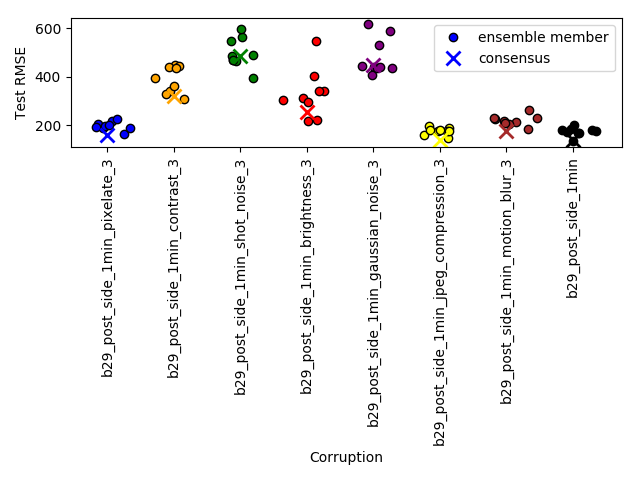

[188.41009748396985, 207.48372408024937, 165.67676324162105, 219.8486210401819, 194.04853610128188, 198.2679900298612, 228.34202537041585, 189.95807712993968, 203.12820563901033]
[308.78147327969066, 447.7124839917986, 340.17085705081183, 444.0069052414581, 328.4823817269204, 394.94612958079915, 442.0128143771871, 361.9113646866085, 436.9200240391547]
[469.8716494799177, 562.7593939995107, 463.61144385484005, 546.7291672836461, 597.0081793454166, 397.20193255498435, 489.2383477009658, 485.92313894439263, 470.81868724759056]
[217.71721828202493, 342.68654478046324, 224.21821149510802, 312.756214717498, 547.2730911895122, 404.3323055934672, 296.2204186147718, 342.58368089627044, 303.9960199757864]
[437.35725618318884, 616.7640860879637, 438.9965843883623, 533.3427815888782, 587.5451108056055, 408.762948469419, 436.4086831950293, 442.8195645764414, 444.5858184107853]
[160.2844927208232, 188.30818188218407, 149.74350700094425, 175.31772826097762, 176.06391297912168, 180.33365625389987, 197

In [13]:
plt.style.use("default")
interval = 20
corrs3 = [f"{videoname}_pixelate_3",
         f"{videoname}_contrast_3",
         f"{videoname}_shot_noise_3",
         f"{videoname}_brightness_3",
         f"{videoname}_gaussian_noise_3",
         f"{videoname}_jpeg_compression_3",
         f"{videoname}_motion_blur_3",
         f"{videoname}"]
colors = ["blue","orange","green","red","purple","yellow","brown","black"]
ensemble = [i for i in range(9)]
fig,ax = plt.subplots()
for pi,p in enumerate(corrs3):
    jit = np.random.randn(len(ensemble))*3
    vals = ensemble_rmses[p]
    ensvals = [vals[i] for i in ensemble]
    print(ensvals)
    if pi == 0:
        ax.plot([pi*interval+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],label = "ensemble member",markeredgecolor = "black")
        ax.plot(pi*interval,vals["median"],marker = "x",color=colors[pi],label = "consensus",markersize = 10,linestyle="None",markeredgewidth=2)
    else:
        ax.plot([pi*interval+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],markeredgecolor = "black")
        ax.plot(pi*interval,vals["median"],marker = "x",color=colors[pi],markersize = 10,linestyle = "None",markeredgewidth=2)
ax.set_ylabel("Test RMSE")
ax.set_xlabel("Corruption")
ax.set_xticks([i*interval for i in range(len(corrs3))])
plt.legend(numpoints = 1)
ax.set_xticklabels(["{}".format(cr) for cr in corrs3],rotation ="vertical")
plt.tight_layout()
plt.savefig("rmseplot_corrupted_erica_severity_3.png")